# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Image-features-exercise" data-toc-modified-id="Image-features-exercise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image features exercise</a></div><div class="lev2 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></div><div class="lev2 toc-item"><a href="#Extract-Features" data-toc-modified-id="Extract-Features-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Extract Features</a></div><div class="lev2 toc-item"><a href="#Train-SVM-on-features" data-toc-modified-id="Train-SVM-on-features-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train SVM on features</a></div><div class="lev3 toc-item"><a href="#Inline-question-1:" data-toc-modified-id="Inline-question-1:-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Inline question 1:</a></div><div class="lev2 toc-item"><a href="#Neural-Network-on-image-features" data-toc-modified-id="Neural-Network-on-image-features-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Neural Network on image features</a></div><div class="lev1 toc-item"><a href="#Bonus:-Design-your-own-features!" data-toc-modified-id="Bonus:-Design-your-own-features!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bonus: Design your own features!</a></div><div class="lev1 toc-item"><a href="#Bonus:-Do-something-extra!" data-toc-modified-id="Bonus:-Do-something-extra!-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bonus: Do something extra!</a></div>

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import os, pickle ##
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

filename = 'features_X_list.pkl' ##

if os.path.isfile(filename): ##
    print("Load previously created dataset ... ...")
    with open(filename, 'rb') as f:
        X_train_feats, X_val_feats, X_test_feats = pickle.load(f)
    print("Loading completed.")
else:
    num_color_bins = 10 # Number of bins in the color histogram
    feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
    X_train_feats = extract_features(X_train, feature_fns, verbose=True)
    X_val_feats = extract_features(X_val, feature_fns)
    X_test_feats = extract_features(X_test, feature_fns)

    # Preprocessing: Subtract the mean feature
    mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
    X_train_feats -= mean_feat
    X_val_feats -= mean_feat
    X_test_feats -= mean_feat

    # Preprocessing: Divide by standard deviation. This ensures that each feature
    # has roughly the same scale.
    std_feat = np.std(X_train_feats, axis=0, keepdims=True)
    X_train_feats /= std_feat
    X_val_feats /= std_feat
    X_test_feats /= std_feat

    # Preprocessing: Add a bias dimension
    X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
    X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
    X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
    
    with open(filename, 'wb') as f:
        pickle.dump([X_train_feats, X_val_feats, X_test_feats], f)

Load previously created dataset ... ...
Loading completed.


## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [21]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

from itertools import product
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr, reg in product(learning_rates, regularization_strengths):
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1000,
              batch_size=200, verbose=False);
    pred_train = svm.predict(X_train_feats);
    pred_val = svm.predict(X_val_feats);
    train_accuracy = np.mean(pred_train == y_train);
    val_accuracy = np.mean(pred_train == y_train);
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy;
        best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.108408 val accuracy: 0.108408
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.091163 val accuracy: 0.091163
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.297469 val accuracy: 0.297469
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.100286 val accuracy: 0.100286
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.412510 val accuracy: 0.412510
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.400898 val accuracy: 0.400898
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415286 val accuracy: 0.415286
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.406959 val accuracy: 0.406959
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.346469 val accuracy: 0.346469
best validation accuracy achieved during cross-validation: 0.415286


In [15]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.42


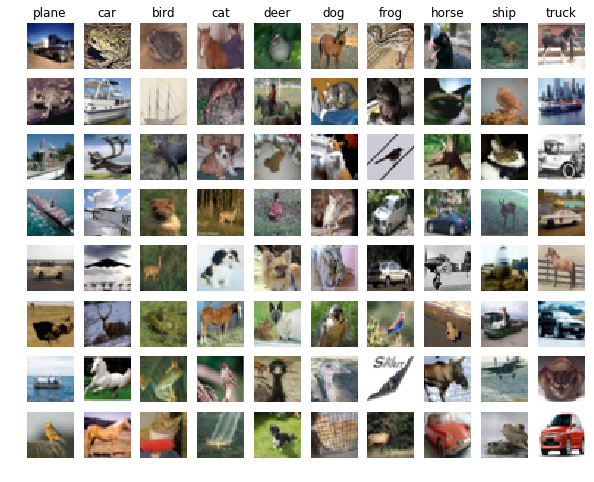

In [16]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

**My Answer**
Th misclassified pictures do not seem to have a consistent orientation with the label it is classified into. An animal has an equal likely chance of being misclassified as a vehicle and vice versa. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [24]:
print(X_train_feats.shape)

(49000, 155)


In [63]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

from itertools import product
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# coarse tuning
best_acc = 0
learning_rates = [3, 1, 3e-1, 1e-1, 3e-2, 1e-2];
regs = [0, 1, 10, 50, 100];
num_epoch = 5; batch_size = 200;
num_iters = num_epoch*X_train_feats.shape[0]//batch_size

for lr, reg in product(learning_rates, regs):
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val
                      , learning_rate=lr, reg=reg, num_iters=num_iters
                      , batch_size=batch_size, verbose=False)
    pred_train = net.predict(X_train_feats)
    train_accuracy = np.mean(pred_train==y_train)
    pred_val = net.predict(X_val_feats)
    val_accuracy = np.mean(pred_val==y_val)
    print('Learning rate: %s, reg: %s, training accuracy: %.4f, validation accuracy: %.4f' \
          %(str(lr), str(reg), train_accuracy, val_accuracy))
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Learning rate: 3, reg: 0, training accuracy: 0.6845, validation accuracy: 0.5190


d:\Wei Ann Lim\Documents\github\Stanford_CS231n_CNN\assignment1\cs231n\classifiers\neural_net.py:100: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
d:\Wei Ann Lim\Documents\github\Stanford_CS231n_CNN\assignment1\cs231n\classifiers\neural_net.py:101: RuntimeWarning: invalid value encountered in multiply
  correct_class_scores = np.sum(indicator*exp_scores, axis=1)
d:\Wei Ann Lim\Documents\github\Stanford_CS231n_CNN\assignment1\cs231n\classifiers\neural_net.py:117: RuntimeWarning: invalid value encountered in true_divide
  dZ2 = exp_scores/np.sum(exp_scores, axis=1, keepdims=True) - indicator


loss is too large
Learning rate: 3, reg: 1, training accuracy: 0.0223, validation accuracy: 0.0160
loss is too large
Learning rate: 3, reg: 10, training accuracy: 0.0744, validation accuracy: 0.0970
loss is too large
Learning rate: 3, reg: 50, training accuracy: 0.1048, validation accuracy: 0.1000
loss is too large

d:\Wei Ann Lim\Documents\github\Stanford_CS231n_CNN\assignment1\cs231n\classifiers\neural_net.py:103: RuntimeWarning: invalid value encountered in true_divide
  loss = np.mean(-np.log(correct_class_scores/np.sum(exp_scores, axis=1)))



Learning rate: 3, reg: 100, training accuracy: 0.1043, validation accuracy: 0.1030
Learning rate: 1, reg: 0, training accuracy: 0.7054, validation accuracy: 0.5540


d:\Wei Ann Lim\Documents\github\Stanford_CS231n_CNN\assignment1\cs231n\classifiers\neural_net.py:103: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-np.log(correct_class_scores/np.sum(exp_scores, axis=1)))


loss is too large
Learning rate: 1, reg: 1, training accuracy: 0.0427, validation accuracy: 0.0350
loss is too large
Learning rate: 1, reg: 10, training accuracy: 0.0552, validation accuracy: 0.0490
loss is too large
Learning rate: 1, reg: 50, training accuracy: 0.0876, validation accuracy: 0.0840
loss is too large
Learning rate: 1, reg: 100, training accuracy: 0.0811, validation accuracy: 0.0860
Learning rate: 0.3, reg: 0, training accuracy: 0.6168, validation accuracy: 0.5640
Learning rate: 0.3, reg: 1, training accuracy: 0.0997, validation accuracy: 0.1130
loss is too large
Learning rate: 0.3, reg: 10, training accuracy: 0.0781, validation accuracy: 0.0670
loss is too large
Learning rate: 0.3, reg: 50, training accuracy: 0.1075, validation accuracy: 0.0940
loss is too large
Learning rate: 0.3, reg: 100, training accuracy: 0.1013, validation accuracy: 0.1000
Learning rate: 0.1, reg: 0, training accuracy: 0.5328, validation accuracy: 0.5110
Learning rate: 0.1, reg: 1, training accurac

In [65]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.565


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!